In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline 
plt.rcParams["figure.figsize"] = [16, 12]
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
sunspots_data = pd.read_csv('data/Sunspots.csv', index_col=0)
sunspots_data['Date'] = pd.to_datetime(sunspots_data['Date'])
sunspots_data.dtypes

Date                                 datetime64[ns]
Monthly Mean Total Sunspot Number           float64
dtype: object

In [3]:
sunspots_data

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3247,2019-08-31,0.5
3248,2019-09-30,1.1
3249,2019-10-31,0.4
3250,2019-11-30,0.5


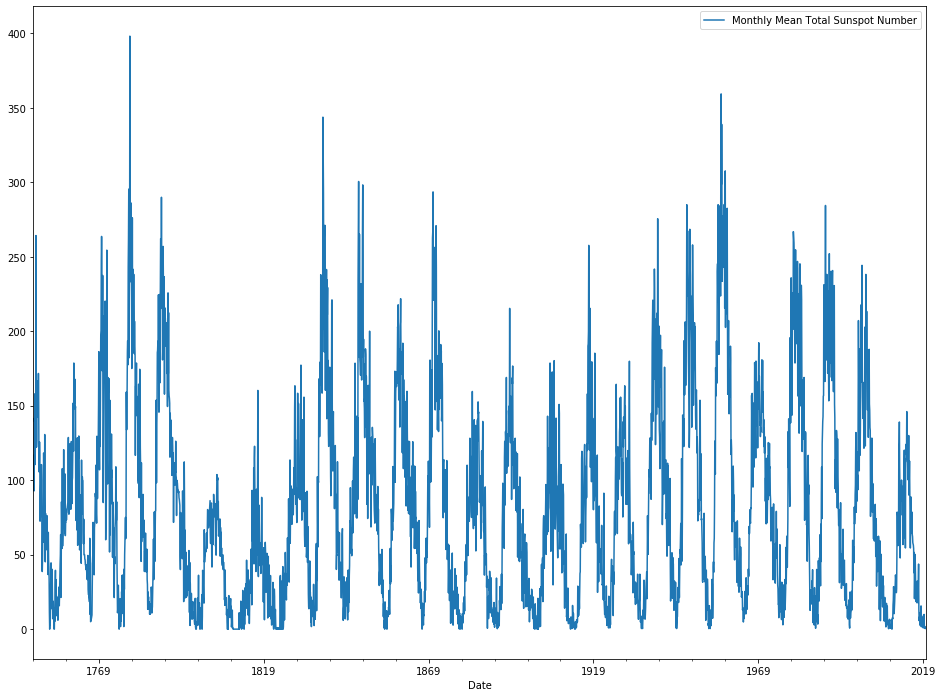

In [4]:
sunspots_data.plot(x=sunspots_data.columns[0], y=sunspots_data.columns[1])

In [5]:
# time_data_stationary = (sunspots_data.iloc[:, 1] - sunspots_data.iloc[:, 1].shift(12)).dropna(inplace=False)
# plt.plot(np.arange(time_data_stationary.shape[0]), time_data_stationary)

### Автокорреляция со смещениями до 600 месяцев (синия линия - 95% доверительный интервал)

(3252,)


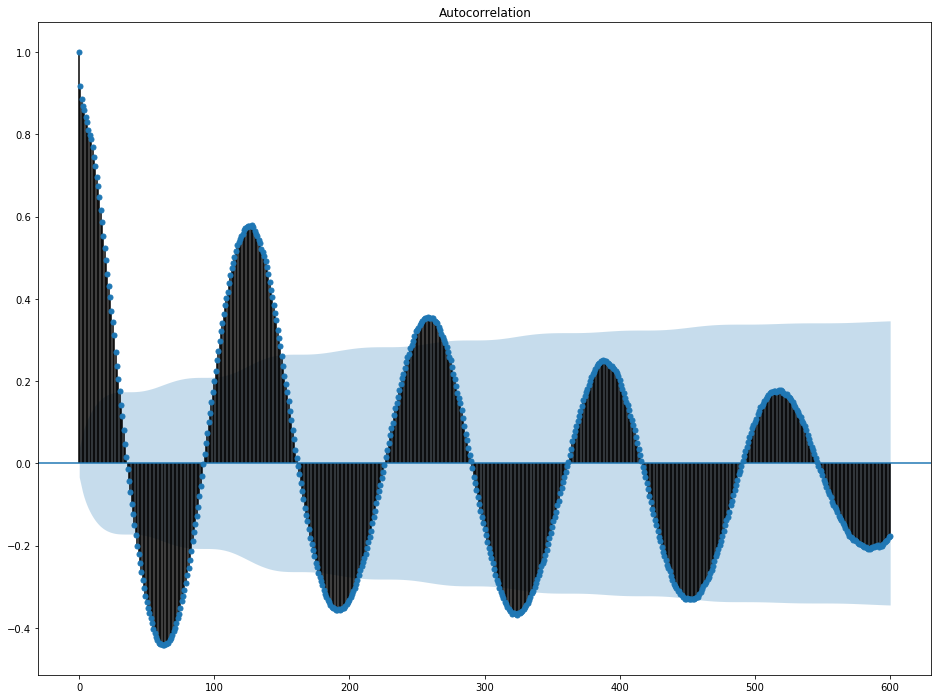

In [6]:
plot_acf(sunspots_data.iloc[:, 1], lags=600)
print(sunspots_data.iloc[:, 1].shape)

In [7]:
# plot_pacf(sunspots_data.iloc[:, 1], lags=600)
# print(sunspots_data.iloc[:, 1].shape)

In [8]:
# plot_acf(time_data_stationary, lags=600)
# print(time_data_stationary.shape)

### Сезонность

(3252,)


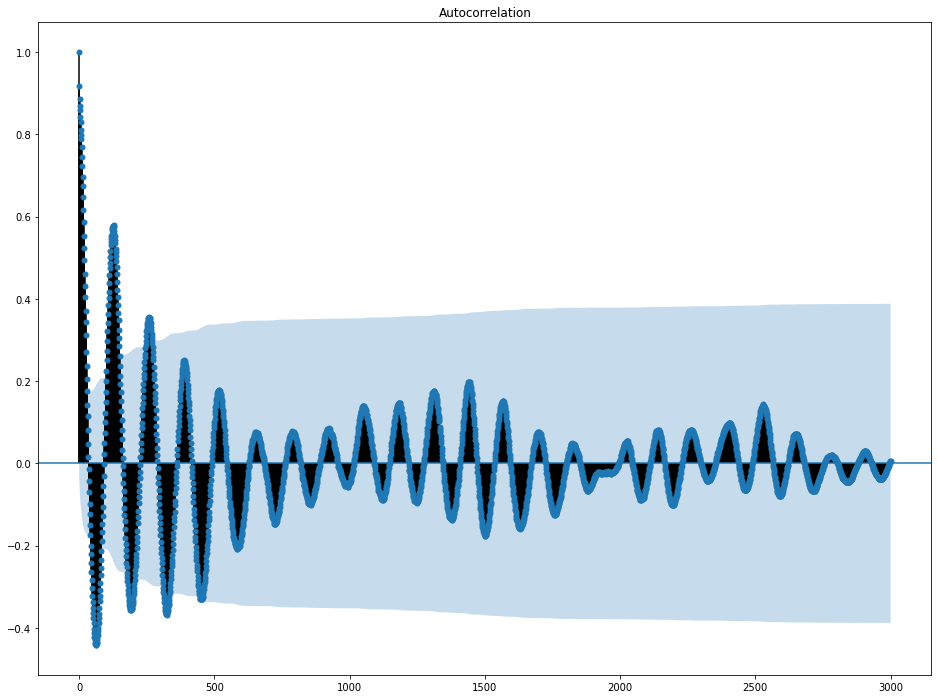

In [9]:
plot_acf(sunspots_data.iloc[:, 1], lags=3000)
print(sunspots_data.iloc[:, 1].shape)

In [10]:
def signum(value):
    result = 0
    result = 1 if value > 0 else result
    result = -1 if value < 0 else result
    return result

def find_peaks(time_series, max_shift=600):
    values = [time_series.autocorr(lag=shift) for shift in range(max_shift)]
    peaks = [(0, values[0])]
    prev_diff_signum = signum(values[1] - values[0])
    prev_value = values[1]
    for i, current_value in enumerate(values[2:]):
        current_diff_signum = signum(current_value - prev_value)
        if current_diff_signum != prev_diff_signum:
            peaks.append((i + 1, current_value))
        prev_diff_signum = current_diff_signum
        prev_value = current_value
    return peaks


peaks = find_peaks(sunspots_data.iloc[:, 1])
peaks

[(0, 1.0),
 (63, -0.44411294039113314),
 (125, 0.5893546702946553),
 (126, 0.5900146003214087),
 (128, 0.5865420725655853),
 (191, -0.36712853041485155),
 (192, -0.36850676278360134),
 (193, -0.3649307679271366),
 (195, -0.3642794436883787),
 (196, -0.3585514021326909),
 (258, 0.3741645271718069),
 (259, 0.37440292964485716),
 (260, 0.37395512276677306),
 (261, 0.3756119987358276),
 (262, 0.36690903840542755),
 (320, -0.3916817233725925),
 (322, -0.393835664006614),
 (324, -0.3920616428344876),
 (388, 0.28340334670169726),
 (393, 0.27029582415286324),
 (394, 0.26492719618730826),
 (448, -0.3785077522345019),
 (450, -0.3784262353519282),
 (452, -0.37964755675631534),
 (454, -0.37992705696038037),
 (455, -0.3780916039250697),
 (515, 0.2128070136990065),
 (516, 0.21351158551930352),
 (518, 0.2160524424127072),
 (523, 0.20631825806432427),
 (524, 0.1977677639928014),
 (581, -0.24965706529688925),
 (582, -0.2533943083027165),
 (585, -0.253339506475137),
 (587, -0.2524517071899336),
 (588, -

Сезонность ~126 месяцев

In [11]:
# plot_acf(time_data_stationary, lags=3000)
# print(time_data_stationary.shape)

### Трэнд

In [12]:
def sesonity_difference(values, interval):
    result = []
    for i in range(interval, values.shape[0]):
        s_diff_value = values[i] - values[i - interval]
        result.append(s_diff_value)
    return np.asarray(result)

trand = sesonity_difference(sunspots_data.iloc[:, 1].values, interval=126)

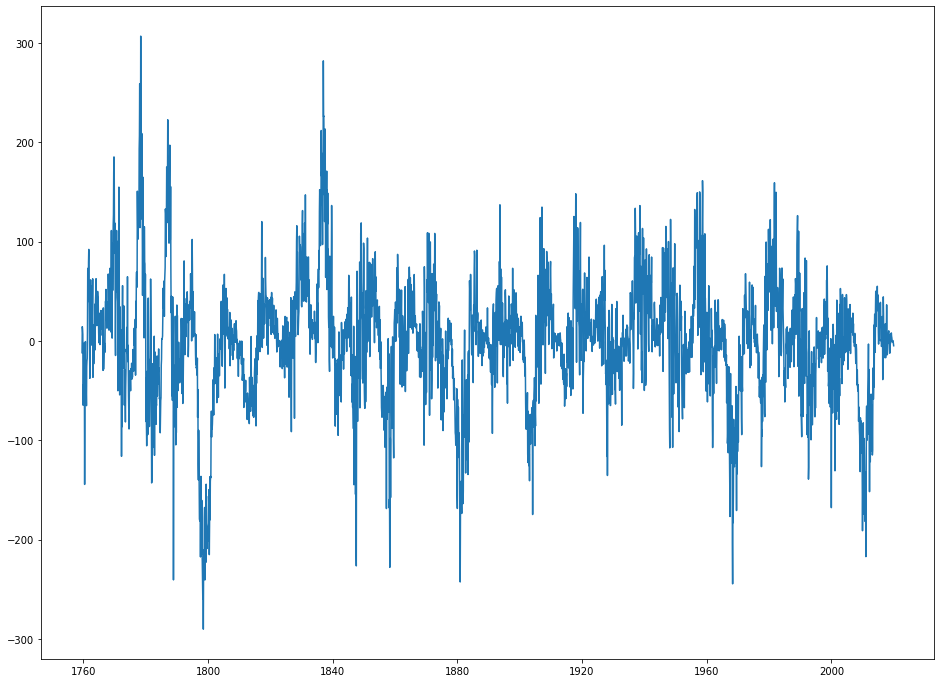

In [13]:
plt.plot(sunspots_data.iloc[-trand.shape[0]:, 0], trand)

(3126,)


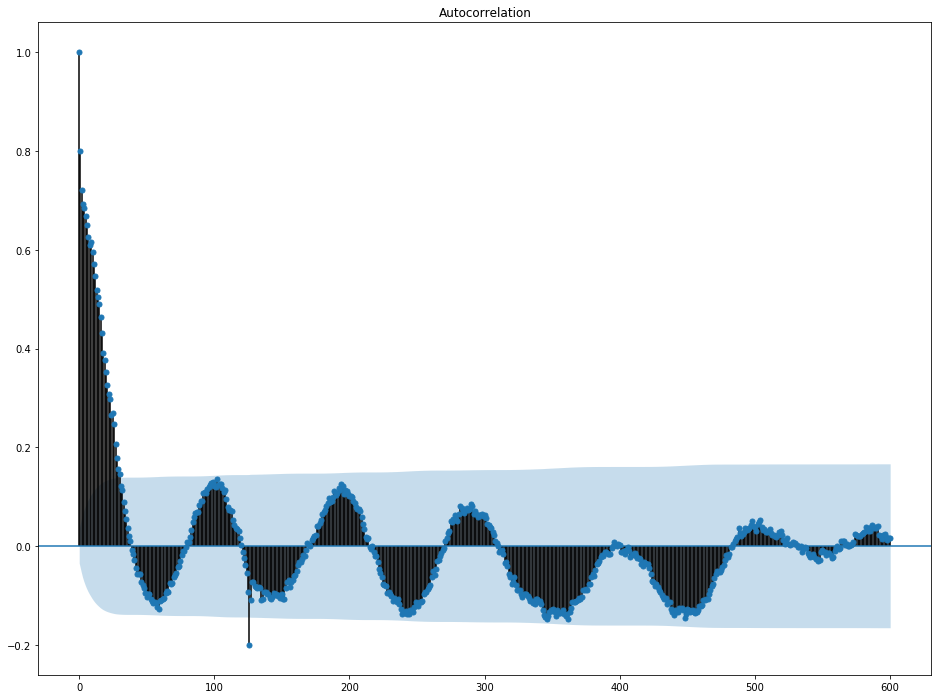

In [14]:
plot_acf(trand, lags=600)
print(trand.shape)

### Разделение данных

In [15]:
sunspots_values = sunspots_data.iloc[:, 1].values
train_size = int(len(sunspots_values) * 0.70)
val_size = int(len(sunspots_values) * 0.15)

train_sunspots_values = sunspots_values[: train_size]
work_sunspots_values = sunspots_values[:train_size + val_size]
val_sunspots_values = sunspots_values[train_size:train_size + val_size]
test_sunspots_values = sunspots_values[train_size + val_size:]

train_sunspots_values.shape, val_sunspots_values.shape, test_sunspots_values.shape

((2276,), (487,), (489,))

### ARIMA

In [69]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

P = 2
D = 1  # Для стационарности. sunspots_data.iloc[:, 1] - sunspots_data.iloc[:, 1].shift(12)
Q = 2

history = [value for value in work_sunspots_values]
predictions = []

for test_value in test_sunspots_values:
    model = ARIMA(history, order=(P,D,Q))
    model_fit = model.fit()
    predicted_value = model_fit.forecast()[0]
    predictions.append(predicted_value)
    history.append(test_value)

In [76]:
mean_squared_error(test_sunspots_values.values, [el[0] for el in predictions])

613.8346472191687

In [87]:
mean_absolute_error(test_sunspots_values.values, [el[0] for el in predictions])

17.964997772524235

In [85]:
test_sunspots_values.values.std() ** 2

5669.773515593506

### RNN

In [17]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
set_session(tf.Session(config=config))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [18]:
from keras import layers, models, optimizers, callbacks, regularizers

In [19]:
def time_data_generator(data: np.ndarray, batch_size, back_size, random_state=42):
    random = np.random.RandomState(random_state)
    values = data.copy()
    while True:
        samples, targets = [], []
        for _ in range(batch_size):
            sample_start_index = random.randint(data.shape[0] - 1 - back_size)
            sample_end_index = sample_start_index + back_size
            target_value_index =  sample_start_index + back_size
            samples.append(values[sample_start_index: sample_end_index])
            targets.append(values[target_value_index])        
        yield np.asarray(samples)[:, :, np.newaxis], np.asarray(targets)

In [20]:
LOOKBACK_SIZE = 50 # 126

train_mean = train_sunspots_values.mean()
train_std = train_sunspots_values.std()

train_generator = time_data_generator(train_sunspots_values, batch_size=16, back_size=LOOKBACK_SIZE)
val_generator = time_data_generator(val_sunspots_values, batch_size=1, back_size=LOOKBACK_SIZE)
test_generator = time_data_generator(test_sunspots_values, batch_size=1, back_size=LOOKBACK_SIZE)

In [21]:
next(train_generator)[0].shape

(16, 50, 1)

In [35]:
def get_model():
    x = input_ = layers.Input((LOOKBACK_SIZE, 1,))
    
#     x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
# #     x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#     x = layers.Bidirectional(layers.LSTM(32))(x)

    x = layers.Conv1D(32, 5, activation='relu')(x)
    x = layers.Conv1D(32, 5, activation='relu')(x)
#     x = layers.MaxPool1D(3)(x)
    
    x = layers.Conv1D(64, 5, activation='relu')(x)
#     x = layers.Conv1D(64, 7, activation='relu')(x)
#     x = layers.MaxPool1D(3)(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dropout(0.5)(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.4)(x)
#     x = layers.Dense(16, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
    output = layers.Dense(1)(x)

    model = models.Model(inputs=input_, outputs=output)
    
    return model

rnn_model = get_model()

rnn_model.compile(optimizers.Adam(), loss='mse', metrics=['mae']) # lr=1e-4
rnn_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 50, 1)             0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 46, 32)            192       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 42, 32)            5152      
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 38, 64)            10304     
_________________________________________________________________
flatten_10 (Flatten)         (None, 2432)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 2432)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 243

In [36]:
# rnn_model.compile(optimizers.Adam(1e-8), loss='mse', metrics=['mae'])
rnn_model.fit_generator(train_generator, steps_per_epoch=200, epochs=50,
                        validation_data=val_generator, validation_steps=val_size - LOOKBACK_SIZE)

Epoch 1/50
200/200 [==============================] - 2s 11ms/step - loss: 1854.7856 - mae: 29.5724 - val_loss: 606.6593 - val_mae: 37.7206
Epoch 2/50
200/200 [==============================] - 2s 9ms/step - loss: 872.8632 - mae: 21.2123 - val_loss: 557.1456 - val_mae: 22.1133
Epoch 3/50
200/200 [==============================] - 2s 9ms/step - loss: 863.9489 - mae: 20.7774 - val_loss: 1237.6421 - val_mae: 24.5042
Epoch 4/50
200/200 [==============================] - 2s 9ms/step - loss: 859.2702 - mae: 21.0922 - val_loss: 874.2468 - val_mae: 22.3874
Epoch 5/50
200/200 [==============================] - 2s 9ms/step - loss: 667.4235 - mae: 18.5533 - val_loss: 2486.3865 - val_mae: 20.4126
Epoch 6/50
200/200 [==============================] - 2s 9ms/step - loss: 703.5349 - mae: 19.1472 - val_loss: 514.7164 - val_mae: 22.6267
Epoch 7/50
200/200 [==============================] - 2s 9ms/step - loss: 678.7539 - mae: 18.6172 - val_loss: 0.0022 - val_mae: 22.3826
Epoch 8/50
200/200 [============

In [37]:
rnn_model.evaluate_generator(test_generator, steps=test_sunspots_values.shape[0])

[323.52618408203125, 17.751646041870117]